# Ames Housing Prices Prediction-Modeling

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad.  
But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this [competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) challenges you to predict the final price of each home.

In this notebook, I plan to show how to clean, explore, analyze and predict home prices based on permanent house qualities. I used only Linearrgression using total home sqrft ratio with overall qaulity of the house 

This notebook uses [data from Kaggle](https://www.kaggle.com/c/dsi-us-4-project-2-regression-challenge/data).

This is the final submitted [submitted  to Kaggle](https://www.kaggle.com/c/dsi-us-4-project-2-regression-challenge/leaderboard). 

##  Library and data Setup 

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits

warnings.filterwarnings('ignore')
import scipy.stats as stats
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import copy
# Configure visual settings:
%matplotlib inline
sns.set_style('whitegrid')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.style.use('ggplot')
np.random.seed(2018)
%load_ext autoreload
%autoreload 2
sns.set()

# Data

In [2]:
train = pd.read_csv('./data/train.csv')

In [3]:
test = pd.read_csv('./data/test.csv')

In [4]:
import warnings
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import skew
from scipy.stats.stats import pearsonr

### Number of rows and columns

In [5]:
data_shape = train.shape
print("Number of columns: "+ str(data_shape[1]))
print("Number of rows: "+ str(data_shape[0]))

Number of columns: 81
Number of rows: 2051


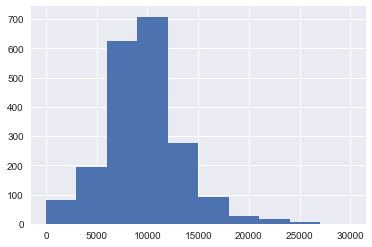

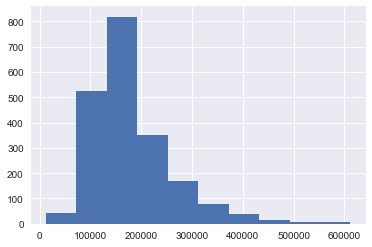

In [6]:
plt.hist(train.LotArea, range=[0, 30000])
plt.show()

plt.hist(train.SalePrice)
plt.show()

AxesSubplot(0.125,0.125;0.775x0.755)


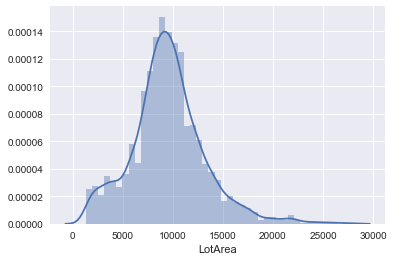

In [7]:
print(sns.distplot((train.LotArea[train.LotArea<30000])))



AxesSubplot(0.125,0.125;0.775x0.755)


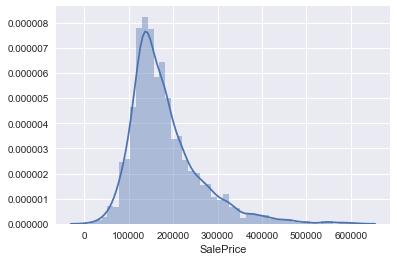

In [8]:
print(sns.distplot((train.SalePrice)))

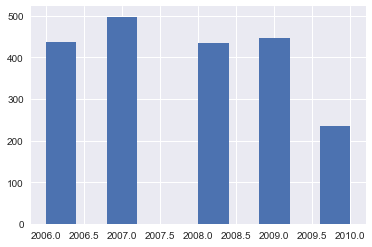

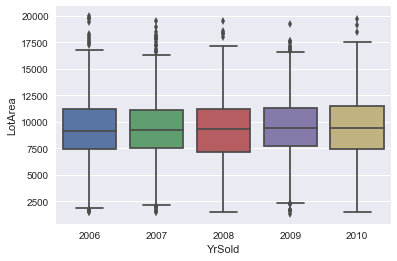

In [9]:
plt.hist(train.YrSold)
plt.show()

sns.boxplot(train.YrSold,train.LotArea[train.LotArea<20000])
#print(sns.distplot((data.YrSold)))

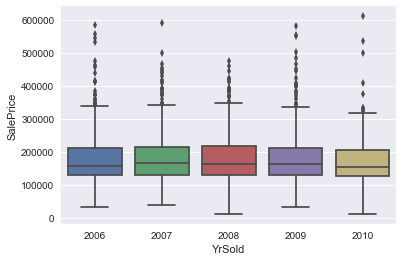

In [10]:
sns.boxplot(train.YrSold,train.SalePrice)

In [11]:
train.head()


,Id,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


### Data Preprocessing
Log transform

In [12]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleType'],
                      test.loc[:,'MSSubClass':'SaleType']))

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

Adding dummy values

In [13]:
all_data = pd.get_dummies(all_data)

In [14]:
all_data = all_data.fillna(all_data.mean())

### Correlation

In [15]:
j = 0
for i in (np.corrcoef(train[numeric_feats])[-1:]):
    print (list(train)[j],"   ", i)
    j+=1

Id     [        nan  0.97987915  0.98357088 ...,  0.99928972  0.9754777   1.        ]


In [16]:
from sklearn.decomposition import PCA
X = all_data[:train.shape[0]]
pca = PCA(n_components=81)
# X is the matrix transposed (n samples on the rows, m features on the columns)
pca.fit(X)

X_new = pca.transform(X)
print (X_new)

[[  2.32102827e+00   1.00572103e+01   1.53634320e+01 ...,   2.97769257e-02
    4.53407799e-01  -7.12853196e-02]
 [  8.81596063e+01   2.46310419e+01  -9.38467666e-01 ...,  -1.86866814e-01
    3.93912548e-01  -5.93725532e-03]
 [ -2.28408976e+02   3.84928522e+00   2.77695143e+01 ...,  -8.59973786e-02
    2.85928183e-02  -1.75469059e-01]
 ..., 
 [ -1.38211813e+02  -6.02650004e+01  -8.03049963e+00 ...,  -1.03821415e-01
    1.59104113e-01   5.50363989e-01]
 [ -1.82296132e+02  -1.81284424e+01  -1.68469172e+01 ...,  -1.14497263e-01
   -2.40010570e-01  -8.21537402e-03]
 [ -2.79152246e+01   4.00403270e+01  -4.06461918e-01 ...,  -5.25334560e-02
    2.54527636e-01  -1.06676793e-01]]


In [17]:
from sklearn.feature_selection import VarianceThreshold
X = all_data[:train.shape[0]]
print (X.shape[1])
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)
print (X.shape[1])

298
298


### Creating test and train set

In [18]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [19]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.cross_validation import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="mean_squared_error", cv = 5))
    return(rmse)

### Implementing Ridge Regression

In [20]:
model_ridge = Ridge()

In [21]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'rmse')

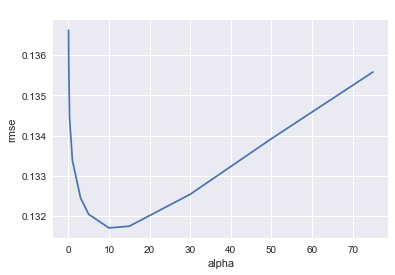

In [22]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = " ")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [23]:
cv_ridge.min()

0.13170760790023134

### Implementing Lasso Regression

In [24]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [25]:
rmse_cv(model_lasso).mean()

0.13167278838396518

In [26]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [27]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 116 variables and eliminated the other 182 variables


In [28]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5,1,'Coefficients in the Lasso Model')

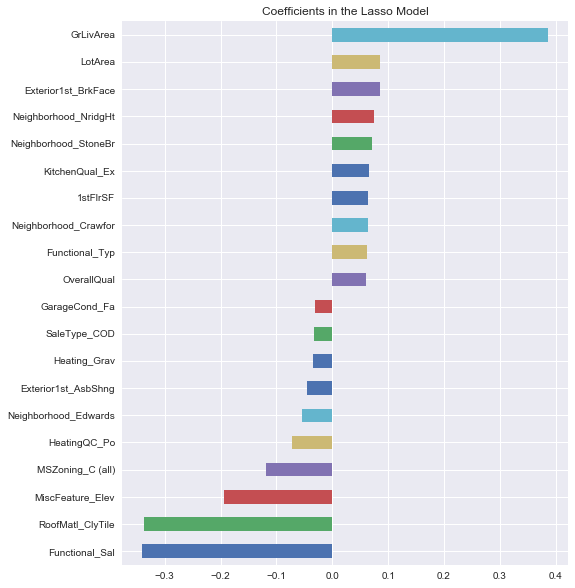

In [29]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [30]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [31]:
modelridge = RidgeCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
ridge_preds = np.expm1(modelridge.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

### Predicting Final Values

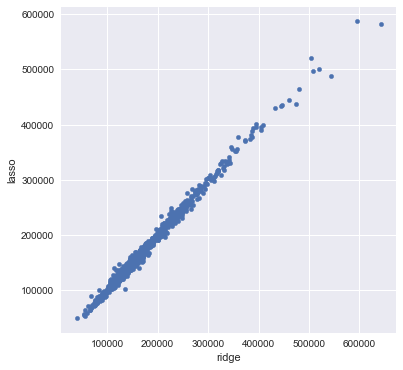

In [32]:
predictions = pd.DataFrame({"ridge":ridge_preds, "lasso":lasso_preds})

predictions.plot(x = "ridge", y = "lasso", kind = "scatter")

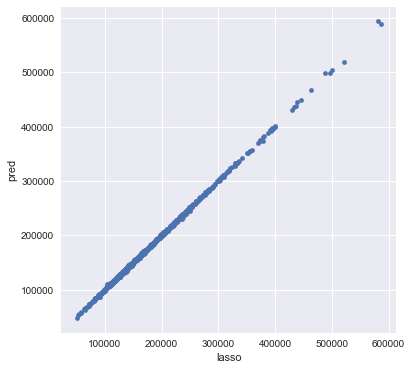

In [33]:
pred = 0.8*lasso_preds + 0.2*ridge_preds
predictions = pd.DataFrame({"lasso":lasso_preds,"pred":pred})
predictions.plot( x = "lasso", y = "pred",kind = "scatter")
output = pd.DataFrame()

In [34]:
print (test.Id,pred)
output = pd.DataFrame({"id":test.Id, "SalePrice":pred})
output.to_csv("./data/lassridge_sol.csv", index = False)

0      2658
1      2718
2      2414
3      1989
4       625
5       333
6      1327
7       858
8        95
9      1568
10     2482
11     1364
12     2584
13      818
14     2673
15     2089
16     1297
17      790
18     2616
19      720
20      222
21      557
22     1148
23     2766
24      534
25     1452
26      630
27     2648
28      125
29     1904
       ... 
849     933
850    2784
851     972
852     599
853    2614
854    2582
855    1409
856     175
857     352
858     976
859    2134
860     984
861    2396
862    1673
863     404
864     607
865     814
866     868
867    2271
868    1633
869     337
870    2765
871    1746
872     368
873    2806
874    1662
875    1234
876    1373
877    1672
878    1939
Name: Id, Length: 879, dtype: int64 [ 123852.99085032  153910.65898702  223435.01848837  105435.98743964
  174531.45437626   93489.92274293  111431.62120424  155852.59314373
  175753.93037044  174436.3753146   156131.16129282  125185.0663625
  145272.08630421  280797.

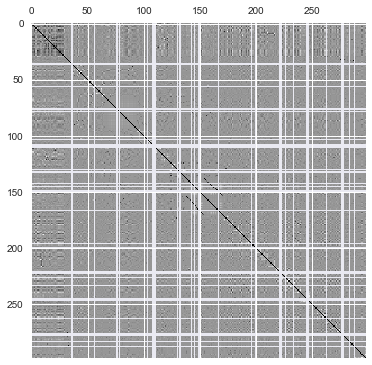

In [36]:
plt.matshow(X_test.corr())

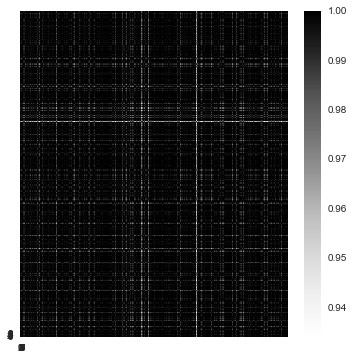

In [37]:
from pylab import pcolor, show, colorbar, xticks, yticks
R = np.corrcoef(X_test)
pcolor(R)
colorbar()
yticks(np.arange(0.5,10.5),range(0,10))
xticks(np.arange(0.5,10.5),range(0,10))
show()

In [38]:
j = 0
for i in (np.corrcoef(train[numeric_feats])[-1:]):
    print (list(train)[j],"   ", i)
    j+=1

Id     [        nan  0.97987915  0.98357088 ...,  0.99928972  0.9754777   1.        ]


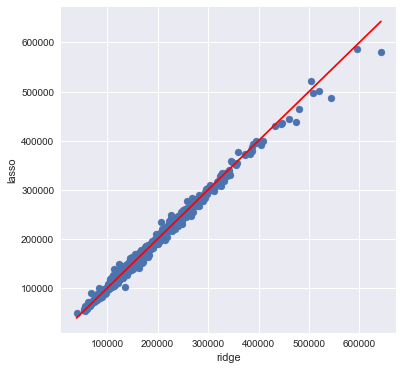

In [39]:
plt.scatter(ridge_preds, lasso_preds)
plt.xlabel('ridge')
plt.ylabel('lasso')
plt.plot( [min(ridge_preds),max(ridge_preds)], [min(ridge_preds),max(ridge_preds)], c="red")

In [40]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

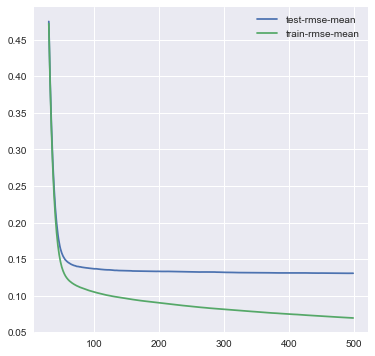

In [41]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [42]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [43]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

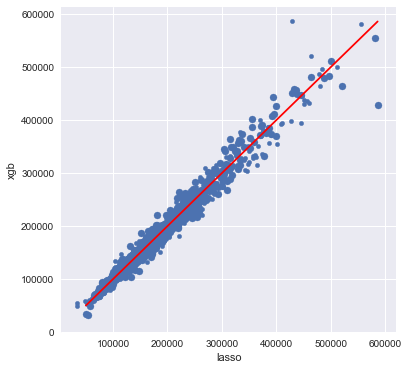

In [44]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

plt.scatter(lasso_preds,xgb_preds)
plt.xlabel('lasso')
plt.ylabel('xgb')
plt.plot( [min(lasso_preds),max(lasso_preds)], [min(lasso_preds),max(lasso_preds)], c="red")